In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

In [13]:
def update_labels_df(labels_df: pd.DataFrame) -> pd.DataFrame:

    labels_df.sort_values("start_time", inplace=True)
    new_labels = []

    for idx in range(len(labels_df) - 1):
        current_label = labels_df.iloc[idx]
        next_label = labels_df.iloc[idx + 1]
        
        time_diff = float(next_label["start_time"]) - float(current_label["end_time"])
        if time_diff > 8:
            new_label = {"start_time": current_label["end_time"], "end_time": next_label["start_time"], "label": "x"}
            new_labels.append(new_label)
    print(f"Added {len(new_labels)} new labels")
    
    new_labels_df = pd.concat([pd.DataFrame(new_labels), labels_df]).sort_values("start_time").reset_index(drop=True)
    
    return new_labels_df


# Load the data

def update_data_file(file_name, new_labels_df): 

    matching_labels_df = new_labels_df[new_labels_df["label"] != "s"].reset_index(drop=True)

    gesture_dict = {}
    with h5py.File(file_name, 'r') as f:
        gestures = [key for key in f.keys() if not key.startswith("data")]
            
        # sort them by time
        gestures = sorted(gestures, key=lambda x: int(x.split("_")[-1]))
        
        # find out time shift
        gesture_start = [g for g in gestures if g.startswith("s_")][0]
        label_gesture_start = new_labels_df[new_labels_df["label"] == "s"].iloc[0]
        time_offset = f[gesture_start]["start_time"] - label_gesture_start["start_time"]
        
        # find out linear index transformation
        index_1, time_1 = f[gestures[0]]["start_index"][()], f[gestures[0]]["start_time"][()]
        index_2, time_2 = f[gestures[-1]]["end_index"][()], f[gestures[-1]]["end_time"][()]
        a = (index_2 - index_1) / (time_2 - time_1)
        b = index_1 - a * time_1

        
        
        gestures = [g for g in gestures if not g.startswith("s_")]
        # iterate over gestures
        gesture_id = 0
        for idx, label in matching_labels_df.iterrows():
            
            if gesture_id >= len(gestures):
                break
                
            
            #print(f"{idx}: {label['label']} - {-label['start_time'] + label['end_time']}")
            matching_gest = gestures[gesture_id]
            matching_gest_name = f[matching_gest]["label"][()].decode("utf-8")

            if matching_gest_name != label["label"]: # no match
                #print(f"Inserting gesture {label['label']} at time {label['start_time']}")
                
                gesture_to_insert_label = "x"
                gesture_to_insert_start_time = label["start_time"] + time_offset
                gesture_to_insert_end_time = label["end_time"] + time_offset
                gesture_to_insert_name = f"{gesture_to_insert_label}_{int(gesture_to_insert_start_time*1000)}"
                gesture_to_insert_start_index = int(a * gesture_to_insert_start_time + b)
                gesture_to_insert_end_index = int(a * gesture_to_insert_end_time + b)
                
                
                #print(f"Gesture: {gesture_to_insert_label}")
                #print(f"Start Time: {gesture_to_insert_start_time}")
                #print(f"End Time: {gesture_to_insert_end_time}")
                #print(f"Start Index: {gesture_to_insert_start_index}")
                #print(f"End Index: {gesture_to_insert_end_index}")
                #print(f"Name: {gesture_to_insert_name}")
                
                #f.create_group(gesture_to_insert_name)
                #f[gesture_to_insert_name].create_dataset("label", data=gesture_to_insert_label.encode("utf-8"))
                #f[gesture_to_insert_name].create_dataset("start_time", data=gesture_to_insert_start_time)
                #f[gesture_to_insert_name].create_dataset("end_time", data=gesture_to_insert_end_time)
                #f[gesture_to_insert_name].create_dataset("start_index", data=gesture_to_insert_start_index)
                #f[gesture_to_insert_name].create_dataset("end_index", data=gesture_to_insert_end_index)
            
                continue
            
            #print(f"Gesture: {matching_gest_name}")
            #print(f"Start Time: {f[matching_gest]['start_time'][()]}")
            #print(f"End Time: {f[matching_gest]['end_time'][()]}")
            #print(f"Start Index: {f[matching_gest]['start_index'][()]}")
            #print(f"End Index: {f[matching_gest]['end_index'][()]}")
            
            gesture_id += 1
        




,Name,file_name,Session_ID,Recording_ID
0,lars,participant_lars_1.hdf5,1,1
1,lars,participant_lars_2.hdf5,2,2
2,lars,participant_lars_3.hdf5,3,3
3,lars,participant_lars_4.hdf5,4,4
4,dominik,participant_dominik_1.hdf5,1,5
...,...,...,...,...
268,gonzalo,participant_gonzalo_4.hdf5,4,271
269,mollyagain,participant_mollyagain_1.hdf5,1,272
270,mollyagain,participant_mollyagain_2.hdf5,2,273
271,mollyagain,participant_mollyagain_3.hdf5,3,274


In [101]:
partcipant_list = pd.read_excel(r"C:\Users\lhauptmann\Code\WristPPG2\data\Recording_protocol_2.xlsx", sheet_name="recordings")
partcipant_list["file_name"] = partcipant_list.apply(lambda x: f"participant_{x['Name'].lower()}_{int(x['Session_ID'])}.hdf5", axis=1)
partcipant_list = partcipant_list[["Name", "file_name", "Session_ID", "Recording_ID"]]
partcipant_list.loc[:,"Name"] = partcipant_list["Name"].str.lower()

dataset_path = r"C:\Users\lhauptmann\Code\WristPPG2\data\dataset"
labels_path = r"C:\Users\lhauptmann\Code\WristPPG2\data\labels"

for idx, session in partcipant_list.iterrows():
    
    participant = session["Name"]
    session = int(session["Session_ID"])
    print(f"Processing participant {participant} session {session}")

    file_name = os.path.join(dataset_path, f"participant_{participant}", f"participant_{participant}_{session}.hdf5")
    
    if not os.path.exists(file_name):
        print(f"File {file_name} does not exist")
        continue

    recording_id = partcipant_list[(partcipant_list["Session_ID"] == session) & (partcipant_list["Name"] == participant)]["Recording_ID"].values[0]
    labels_df = pd.read_csv(os.path.join(labels_path,f"label_{recording_id:03d}.csv"))
    
    new_labels_df = update_labels_df(labels_df)
    update_data_file(file_name, new_labels_df)
    
    



Processing participant lars session 1
Added 1 new labels
Processing participant lars session 2
Added 0 new labels
Processing participant lars session 3
Added 0 new labels
Processing participant lars session 4
Added 0 new labels
Processing participant dominik session 1
Added 1 new labels
Processing participant dominik session 2
Added 1 new labels
Processing participant dominik session 3
Added 2 new labels
Processing participant dominik session 4
File C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_dominik\participant_dominik_4.hdf5 does not exist
Processing participant tobias session 1
Added 3 new labels
Processing participant tobias session 2
Added 2 new labels
Processing participant tobias session 3
Added 0 new labels
Processing participant tobias session 4
Added 0 new labels
Processing participant ying session 1
Added 5 new labels
Processing participant ying session 2
Added 2 new labels
Processing participant ying session 3
Added 2 new labels
Processing participant ying s

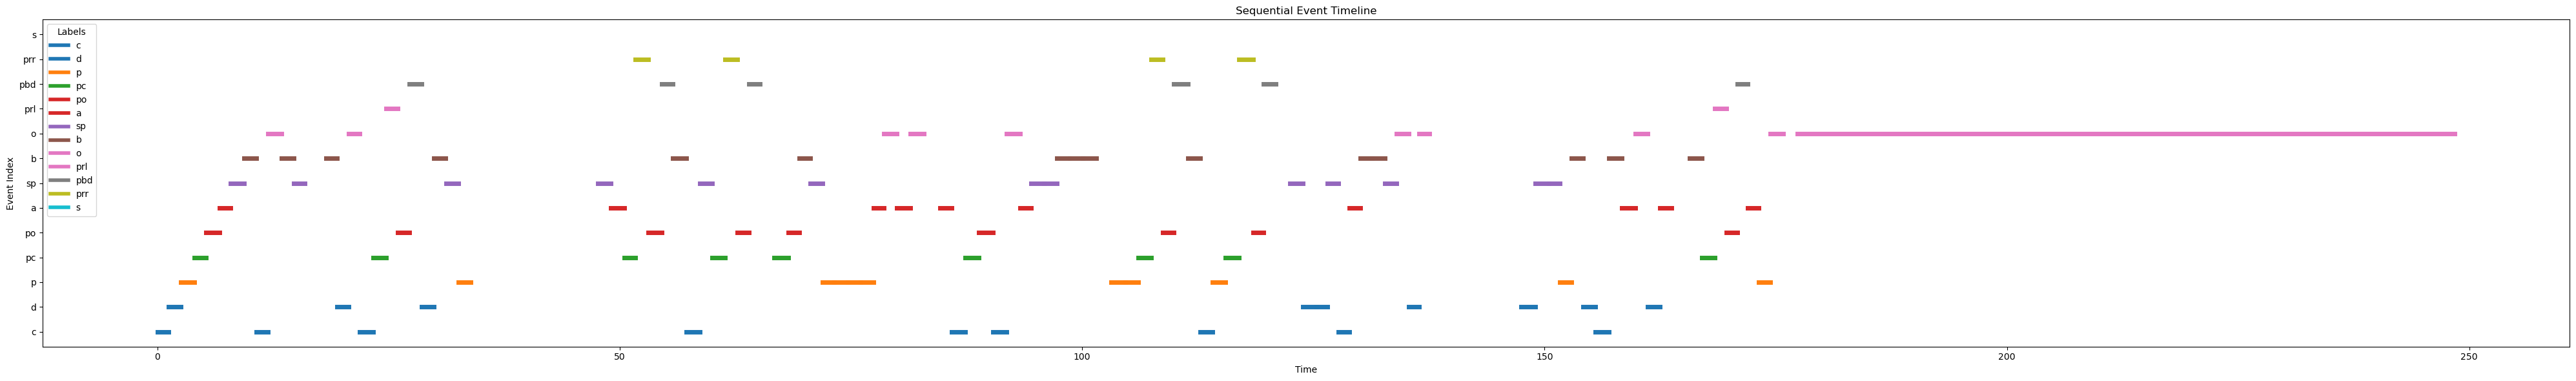

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

labels_df_selected = labels_df.iloc[50:]

# Assign unique colors to each label
unique_labels = labels_df_selected['label'].unique()
label_colors = {label: plt.cm.tab10(i / len(unique_labels)) for i, label in enumerate(unique_labels)}

# Create the plot
fig, ax = plt.subplots(figsize=(40, 6))
zero_time = labels_df_selected['start_time'].min()

for idx, row in labels_df_selected.iterrows():
    ax.plot(
        [row['start_time'] - zero_time, row['end_time'] - zero_time],
        [row['label'], row['label']],  # Sequentially place events on the y-axis
        color=label_colors[row['label']],
        lw=5
    )

plt.title("Sequential Event Timeline")
plt.xlabel("Time")
plt.ylabel("Event Index")

# Add legend for labels
handles = [plt.Line2D([0], [0], color=label_colors[label], lw=4) for label in unique_labels]
ax.legend(handles, unique_labels, title="Labels", loc='upper left')

plt.tight_layout()
plt.show()

In [67]:
new_labels_df

,start_time,end_time,label
0,1.733232e+09,1.733232e+09,s
1,1.733232e+09,1.733232e+09,a
2,1.733232e+09,1.733232e+09,p
3,1.733232e+09,1.733232e+09,o
4,1.733232e+09,1.733232e+09,o
...,...,...,...
156,1.733232e+09,1.733232e+09,a
157,1.733232e+09,1.733232e+09,p
158,1.733232e+09,1.733232e+09,o
159,1.733232e+09,1.733232e+09,o
